### СОЗДАНИЕ ПРИЗНАКОВ (FEATURE EXTRACTION)

![fe_0](images/fe_0.png)

In [58]:
import pandas as pd

data = pd.read_csv('data/wine_cleared.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            129971 non-null  object 
 4   points                 129971 non-null  int64  
 5   price                  129971 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               129971 non-null  object 
 8   taster_name            129971 non-null  object 
 9   taster_twitter_handle  129971 non-null  object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 12.9+ MB


,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


#### РАЗБОР ДАТЫ И ВРЕМЕНИ
![datatime](images/datetime.png)

#### РАЗБОР ЧИСЛОВЫХ ВЕЛИЧИН

In [59]:
data['price_round'] = data['price'].round().astype(int)

Для таких преобразований важен контекст. В контексте вина для сомелье цена в 35$ и 35.363389$ одинакова. Вы делаете округление признака, чтобы модель также не сосредотачивалась на сотых. Это может помочь улучшить предсказание.

Однако такое преобразование неуместно в ситуациях, когда сотые важны. Например, при предсказании курса лиры стоимость валюты в 6.12 руб. и в 6.84 руб. — абсолютно разные ситуации. 

#### РАЗБОР ТЕКСТА
##### [REGEX in practice](https://tproger.ru/translations/regular-expression-python)

In [60]:
regex = '\d{4}' # regex for finding numbers
data['year'] = data['title'].str.findall(regex).str.get(0)

Разберём регулярное выражение \d{4}:

- \d — класс символов, обозначает соответствие цифрам в диапазоне цифр [0-9];
- {4} в шаблоне означает искать четыре вхождения символа, указанного ранее. В нашем случае это будут четырехзначные числа.

Таким образом, \d{4} означает поиск четырехзначных чисел в заданной строке.

##### РАЗБОР КАТЕГОРИЙ

В наборе данных винных обзоров самая популярная страна-производитель вина — США. Возможно, это не случайность, и факт производства в США влияет на рейтинг вина. Выделим этот факт.

Вы можете создать новый бинарный признак is_usa и присвоить ему 1 в случае, если вино произведено в США, иначе — 0.

In [61]:
data['is_usa'] = data['country'].apply(lambda x: 1 if x == 'US' else 0)

Выберите из списка две самых популярных (помимо США) страны, производящих вино.

In [62]:
data['country'].value_counts(ascending=False)[:3]

country
US        54504
France    22093
Italy     19540
Name: count, dtype: int64

In [63]:
data['is_france'] = data['country'].apply(lambda x: 1 if x == 'France' else 0)
data['is_italy'] = data['country'].apply(lambda x: 1 if x == 'Italy' else 0)

display(data['is_france'].sum())
display(data['is_italy'].sum())

22093

19540

***
Также вы можете создавать некие бизнес-правила, гипотезы. О правилах их построения вы узнаете далее в материалах, посвящённых статистическим гипотезам. 

Попробуем вывести правило в определении качества вина: старые вина лучше молодых. В нашем датасете 40 % вин старше 2010 года. 

In [64]:
data['year'] = data['year'].fillna(value=-1)
data['old_wine'] = data['year'].astype(int).apply(lambda x: 1 if (x < 2010 and x != -1) else 0)
display(data['old_wine'].sum())

39781

Создайте новый признак locality из признака title, который будет обозначать название долины/местности производства вина.

Например, в названии вина Rainstorm 2013 Pinot Gris (Willamette Valley) locality будет Willamette Valley. В названии Tandem 2011 Ars In Vitro Tempranillo-Merlot (Navarra) — Navarra.

In [65]:
regex = '\((.*?)\)'
data['locality'] = data['title'].str.findall(regex).str.get(0)

***
#### СОЗДАНИЕ ПРИЗНАКОВ: ВНЕШНИЕ ИСТОЧНИКИ ДАННЫХ
![external_info](images/external_info.png)

Часто маленькие страны с небольшим количеством населения имеют узкую специализацию. Например, в производстве вина особенно успешны Франция, Италия, Испания, Новая Зеландия. Чтобы проверить, влияет ли на качество вина населённость, выясним информацию о населении страны, в котором была произведена бутылка вина. 

In [66]:
country_population = pd.read_csv('data/country_population.csv', sep=';')
country_population.head()

,country,population
0,China,"1,411,778,724"
1,India,"1,386,584,581"
2,US,"333,022,386"
3,Indonesia,"271,350,000"
4,Pakistan,"225,200,000"


In [67]:
display(country_population[country_population['country'] == 'Italy'])

,country,population
24,Italy,"59,097,904"


In [68]:
data = data.join(country_population.set_index('country'), on='country')

In [69]:
country_area = pd.read_csv('data/country_area.csv', sep=';')
country_area.head()

,country,area
0,Russia,17075400.0
1,Canada,9984670.0
2,China,9596960.0
3,US,9372610.0
4,Brazil,8547000.0


Создайте новый признак area_country — площадь страны, аналогичный признаку population.

Какая площадь страны у вина под названием 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))'? Ответ вводите без пробелов, округлите до целых.

In [70]:
data = data.join(country_area.set_index('country'), on='country')
display(data[data['title'] == 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))'])

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,...,winery,price_round,year,is_usa,is_france,is_italy,old_wine,locality,population,area
94,94,US,"Barrel notes are prominent, with aromas of Cre...",Grand Klasse Reserve Lawrence Vineyards,88,22.0,Washington,Columbia Valley (WA),Sean P. Sullivan,@wawinereport,...,Gård,22,2014,1,0,0,0,Columbia Valley (WA,"333,022,386",9372610.0


![suggestions](images/suggestions.png)

***
#### СОЗДАНИЕ ПРИЗНАКОВ: РАБОТА С ФОРМАТОМ "ДАТА-ВРЕМЯ"

![datetime_2](images/datetime_2.png)
![datetime_3](images/datetime_3.png)

In [71]:
import pandas as pd

# инициализируем информацию о звонках
calls_list = [
    [460, '2013-12-17 04:55:39', '2013-12-17 04:55:44', '2013-12-17 04:55:45'],
    [12, '2013-12-16 20:03:20', '2013-12-16 20:03:22', '2013-12-16 20:07:13'],
    [56, '2013-12-16 20:03:20', '2013-12-16 20:03:20', '2013-12-16 20:05:04'],
    [980, '2013-12-16 20:03:20','2013-12-16 20:03:27', '2013-12-16 20:03:29'],
    [396, '2013-12-16 20:08:27', '2013-12-16 20:08:28','2013-12-16 20:12:03'],
    [449, '2013-12-16 20:03:20', '2013-12-16 20:03:25','2013-12-16 20:05:00'],
    [397, '2013-12-16 20:08:25', '2013-12-16 20:08:27', '2013-12-16 20:09:59'],
    [398, '2013-12-16 20:01:23', '2013-12-16 20:01:23', '2013-12-16 20:04:58'],
    [452, '2013-12-16 20:03:20', '2013-12-16 20:03:21','2013-12-16 20:04:55'],
    [440, '2013-12-16 20:03:20', '2013-12-16 20:04:26', '2013-12-16 20:04:32']
]

calls = pd.DataFrame(calls_list, columns=['client_id', 'agent_date', 'created_at', 'end_date'])

# преобразовываем признаки в формат datetime для удобной работы
calls['agent_date'] = pd.to_datetime(calls['agent_date'])
calls['created_at'] = pd.to_datetime(calls['created_at'])
calls['end_date'] = pd.to_datetime(calls['end_date'])

calls

,client_id,agent_date,created_at,end_date
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32


In [72]:
calls['duration'] = (calls['end_date'] - calls['created_at']).dt.seconds
calls

,client_id,agent_date,created_at,end_date,duration
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45,1
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13,231
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04,104
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29,2
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03,215
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00,95
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59,92
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58,215
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55,94
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32,6


In [73]:
calls['time_connection'] = (calls['created_at'] - calls['agent_date']).dt.seconds
display(calls)
display(calls['time_connection'].sum())

,client_id,agent_date,created_at,end_date,duration,time_connection
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45,1,5
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13,231,2
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04,104,0
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29,2,7
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03,215,1
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00,95,5
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59,92,2
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58,215,0
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55,94,1
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32,6,66


89

Создайте новый признак is_connection — факт соединения с клиентом. Признак будет равен 1 в случае, если разговор состоялся и продлился больше 10 секунд, иначе — 0.

В ответ запишите результат выполнения следующего кода: calls['is_connection'].sum().

In [74]:
import numpy as np

calls['is_connection'] = np.where(calls['duration'] > 10, 1, 0)
display(calls['is_connection'].sum())

7

Создайте признак time_diff — разницу в секундах между началом звонка(не разговора) и его окончанием.

В ответ запишите результат выполнения следующего кода: calls['time_diff'].sum().

In [75]:
calls['time_diff'] = (calls['end_date'] - calls['agent_date']).dt.seconds
display(calls['time_diff'].sum())

1144

Итак, мы получили четыре новых признака для нашего набора данных: duration, time_connection, is_connection, time_diff. После генерации признаков из дат исходные признаки agent_date, created_at, end_date нам больше не нужны — передать на вход модели мы им не сможем, так как большинство моделей машинного обучения умеют работать только с числами, даты и текст ей недоступны, поэтому удалим их:

In [76]:
calls = calls.drop(columns=['agent_date', 'created_at', 'end_date'], axis=1)

Создайте признак количество дней с момента произведения вина — years_diff для датасета винных обзоров. За дату отсчёта возьмите 12 января 2022 года. В ответ впишите максимальное количество дней с момента произведения вина. Ответ округлите до целого числа.

In [77]:
# If 'coerce', then invalid parsing will be set as NaT.
data['year'] = pd.to_datetime(data['year'], errors='coerce')
reference_date = pd.to_datetime('2022-01-12')
data['years_diff'] = (reference_date - data['year']).dt.days
display(round(data['years_diff'].max()))

98627

***
#### КОДИРОВАНИЕ ПРИЗНАКОВ. МЕТОДЫ

![encoding_1](images/encoding_1.png)

In [78]:
import category_encoders as ce

# инициализируем информацию об одежде
clothing_list = [
    ['xxs', 'dress'],
    ['xxs', 'skirt'],
    ['xs', 'dress'],
    ['s', 'skirt'],
    ['m', 'dress'],
    ['l', 'shirt'],
    ['s', 'coat'],
    ['m', 'coat'],
    ['xxl', 'shirt'],
    ['l', 'dress']
]

clothing = pd.DataFrame(clothing_list, columns = ['size',  'type'])
clothing

,size,type
0,xxs,dress
1,xxs,skirt
2,xs,dress
3,s,skirt
4,m,dress
5,l,shirt
6,s,coat
7,m,coat
8,xxl,shirt
9,l,dress


##### ПОРЯДКОВОЕ КОДИРОВАНИЕ. ORDINAL ENCODING

![odrinal_encoding](images/ordinal_encoding.png)

In [79]:
# creating OrdinalEncoding object, col - column name, mapping - dict describing the encoding
ord_encoder = ce.OrdinalEncoder(mapping=[{
    'col': 'size',
    'mapping': {'xxs': 1, 'xs': 2, 's': 3,
                'm': 4, 'l': 5, 'xxl': 6}
}])
# applying the ordinary encoding transformation to the df's column
# the double square brackets [['size']] ensure that the result is a DataFrame, not Series
data_bin = ord_encoder.fit_transform(clothing[['size']])
# adding the result to the df
clothing = pd.concat([clothing, data_bin], axis=1)

clothing

,size,type,size
0,xxs,dress,1
1,xxs,skirt,1
2,xs,dress,2
3,s,skirt,3
4,m,dress,4
5,l,shirt,5
6,s,coat,3
7,m,coat,4
8,xxl,shirt,6
9,l,dress,5


![ordinal_encoding_2](images/ordinal_encoding_2.png)

Используйте ранее изученные методы кодирования и закодируйте признак year в датасете винных обзоров порядковым кодированием.



In [80]:
data[['year']].describe()

,year
count,125332
mean,2010-07-06 02:11:58.782114560
min,1752-01-01 00:00:00
25%,2009-01-01 00:00:00
50%,2011-01-01 00:00:00
75%,2013-01-01 00:00:00
max,2017-01-01 00:00:00


In [81]:
unique_years = sorted(data['year'].dropna().unique())
display(unique_years)
year_mapping = {year: (len(unique_years) - i) for i, year in enumerate(unique_years)}

# turning the year col into category for encoding (otherwise, the encoder won't transform the col because it won't recognize it as categorical)
data['year'] = data['year'].astype('category')

# specifying the 'year' col for encoding, otherwise all categorical cols will be encoded
ord_encoder = ce.OrdinalEncoder(mapping=[{
    'col': 'year',
    'mapping': year_mapping
}])
data_bin = ord_encoder.fit_transform(data[['year']]).astype(int)
data = pd.concat([data, data_bin], axis=1)

data.head()

[Timestamp('1752-01-01 00:00:00'),
 Timestamp('1789-01-01 00:00:00'),
 Timestamp('1821-01-01 00:00:00'),
 Timestamp('1827-01-01 00:00:00'),
 Timestamp('1840-01-01 00:00:00'),
 Timestamp('1845-01-01 00:00:00'),
 Timestamp('1847-01-01 00:00:00'),
 Timestamp('1848-01-01 00:00:00'),
 Timestamp('1850-01-01 00:00:00'),
 Timestamp('1852-01-01 00:00:00'),
 Timestamp('1856-01-01 00:00:00'),
 Timestamp('1860-01-01 00:00:00'),
 Timestamp('1868-01-01 00:00:00'),
 Timestamp('1870-01-01 00:00:00'),
 Timestamp('1872-01-01 00:00:00'),
 Timestamp('1875-01-01 00:00:00'),
 Timestamp('1877-01-01 00:00:00'),
 Timestamp('1882-01-01 00:00:00'),
 Timestamp('1887-01-01 00:00:00'),
 Timestamp('1898-01-01 00:00:00'),
 Timestamp('1904-01-01 00:00:00'),
 Timestamp('1912-01-01 00:00:00'),
 Timestamp('1919-01-01 00:00:00'),
 Timestamp('1927-01-01 00:00:00'),
 Timestamp('1929-01-01 00:00:00'),
 Timestamp('1934-01-01 00:00:00'),
 Timestamp('1935-01-01 00:00:00'),
 Timestamp('1941-01-01 00:00:00'),
 Timestamp('1945-01-

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,...,year,is_usa,is_france,is_italy,old_wine,locality,population,area,years_diff,year
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,...,2013-01-01,0,0,1,0,Etna,"59,097,904",301230.0,3298.0,5
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,...,2011-01-01,0,0,0,0,Douro,"10,347,892",92391.0,4029.0,7
2,2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,...,2013-01-01,1,0,0,0,Willamette Valley,"333,022,386",9372610.0,3298.0,5
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,...,2013-01-01,1,0,0,0,Lake Michigan Shore,"333,022,386",9372610.0,3298.0,5
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,...,2012-01-01,1,0,0,0,Willamette Valley,"333,022,386",9372610.0,3664.0,6


##### ОДНОКРАТНОЕ КОДИРОВАНИЕ. ONE-HOT ENCODING

![onehot_encoding](images/onehot_encoding.png)

In [82]:
encoder = ce.OneHotEncoder(cols=['type'], use_cat_names=True)
type_bin = encoder.fit_transform(clothing['type'])
clothing = pd.concat([clothing, type_bin], axis=1)

clothing

,size,type,size,type_dress,type_skirt,type_shirt,type_coat
0,xxs,dress,1,1,0,0,0
1,xxs,skirt,1,0,1,0,0
2,xs,dress,2,1,0,0,0
3,s,skirt,3,0,1,0,0
4,m,dress,4,1,0,0,0
5,l,shirt,5,0,0,1,0
6,s,coat,3,0,0,0,1
7,m,coat,4,0,0,0,1
8,xxl,shirt,6,0,0,1,0
9,l,dress,5,1,0,0,0


![onehot_encoding_2](images/onehot_encoding_2.png)

In [83]:
print('Cols count before encoding:', len(data.columns))

encoder = ce.OneHotEncoder(cols = ['taster_name'], use_cat_names=True)
type_bin = encoder.fit_transform(data['taster_name'])
data = pd.concat([data, type_bin], axis=1)

print('Cols count after encoding:', len(data.columns))

Cols count before encoding: 24
Cols count after encoding: 44


##### ДВОИЧНОЕ КОДИРОВАНИЕ

![binary_encoding_1](images/binary_encoding_1.png)
![binary_encoding_2](images/binary_encoding_2.png)

In [84]:
bin_encoder = ce.BinaryEncoder(cols=['type'])
type_bin = bin_encoder.fit_transform(clothing['type'])
clothing = pd.concat([clothing, type_bin], axis=1)

clothing

,size,type,size,type_dress,type_skirt,type_shirt,type_coat,type_0,type_1,type_2
0,xxs,dress,1,1,0,0,0,0,0,1
1,xxs,skirt,1,0,1,0,0,0,1,0
2,xs,dress,2,1,0,0,0,0,0,1
3,s,skirt,3,0,1,0,0,0,1,0
4,m,dress,4,1,0,0,0,0,0,1
5,l,shirt,5,0,0,1,0,0,1,1
6,s,coat,3,0,0,0,1,1,0,0
7,m,coat,4,0,0,0,1,1,0,0
8,xxl,shirt,6,0,0,1,0,0,1,1
9,l,dress,5,1,0,0,0,0,0,1


Закодируйте признак country двоичным способом.

Сколько новых признаков образовалось после кодирования признака country?

In [85]:
print('Cols count before encoding:', len(data.columns))

bin_encoder = ce.BinaryEncoder(cols=['country'])
type_bin = bin_encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

print('Cols count after encoding:', len(data.columns))

Cols count before encoding: 44
Cols count after encoding: 50


На основе изученного материала определите подходящий способ кодирования признака taster_twitter_handle из датасета винных обзоров и закодируйте его.

В ответе напишите, сколько признаков добавилось после применения кодирования.

In [86]:
print('Cols count before encoding:', len(data.columns))

bin_encoder = ce.BinaryEncoder(cols=['taster_twitter_handle'])
type_bin = bin_encoder.fit_transform(data['taster_twitter_handle'])
data = pd.concat([data, type_bin], axis=1)

print('Cols count after encoding:', len(data.columns))

Cols count before encoding: 50
Cols count after encoding: 55


Определите типы признаков и закодируйте их в соответствии с изученными способами:

In [87]:
list_of_dicts = [
 {'product': 'Product1', 'price': 1200, 'payment_type': 'Mastercard'},
 {'product': 'Product2', 'price': 3600, 'payment_type': 'Visa'},
 {'product': 'Product3', 'price': 7500, 'payment_type': 'Amex'}
]
df = pd.DataFrame(list_of_dicts)

encoder = ce.OneHotEncoder(cols=['product', 'payment_type'], use_cat_names=True)
type_bin = encoder.fit_transform(df[['product', 'payment_type']])
df = pd.concat([df, type_bin], axis=1)

df


,product,price,payment_type,product_Product1,product_Product2,product_Product3,payment_type_Mastercard,payment_type_Visa,payment_type_Amex
0,Product1,1200,Mastercard,1,0,0,1,0,0
1,Product2,3600,Visa,0,1,0,0,1,0
2,Product3,7500,Amex,0,0,1,0,0,1


***
#### ПРЕОБРАЗОВАНИЕ ПРИЗНАКОВ. НОРМАЛИЗАЦИЯ. СТАНДАРТИЗАЦИЯ

![scaling](images/scaling.png)

In [88]:
import matplotlib.style
import numpy as np
# for normalization and standartization
from sklearn import preprocessing
# for plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

np.random.seed(34)

# generating df of random numbers
df = pd.DataFrame({
    # Бета распределение, 5 – значение альфа, 1 – значение бета, 1000 – размер
    'beta': np.random.beta(5, 1, 1000) * 60,
    
    # Экспоненциальное распределение, 10 – "резкость" экспоненты, 1000 – размер
    'exponential': np.random.exponential(10, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 2 – стандартное отклонение, 1000 – количество сэмплов
    'normal_p': np.random.normal(10, 2, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 10 – стандартное отклонение, 1000 – количество сэмплов
    'normal_l': np.random.normal(10, 10, 1000),
})

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(df.columns)

![distro](images/distro.png)

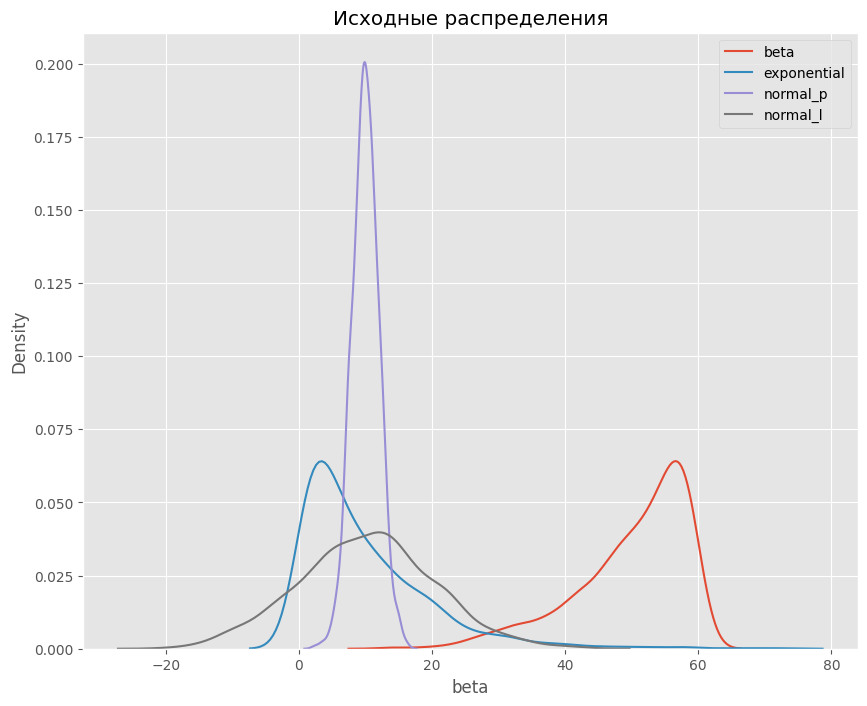

In [89]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df['beta'], ax=ax1, label='beta')
sns.kdeplot(df['exponential'], ax=ax1, label ='exponential')
sns.kdeplot(df['normal_p'], ax=ax1, label ='normal_p')
sns.kdeplot(df['normal_l'], ax=ax1, label ='normal_l')
plt.legend();

In [90]:
df.describe()

,beta,exponential,normal_p,normal_l
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,50.024249,10.028387,9.994006,10.175745
std,8.474545,9.733928,2.013971,10.104004
min,13.854022,0.007617,2.356844,-19.539980
25%,45.793283,2.951421,8.687478,3.566822
50%,52.337504,7.018565,9.983498,10.326331
75%,56.722191,14.022485,11.306914,16.615057
max,59.990640,71.344341,16.214364,42.072915


##### MINMAXSCALER NORMALIZATION

![minmax](images/minmax.png)

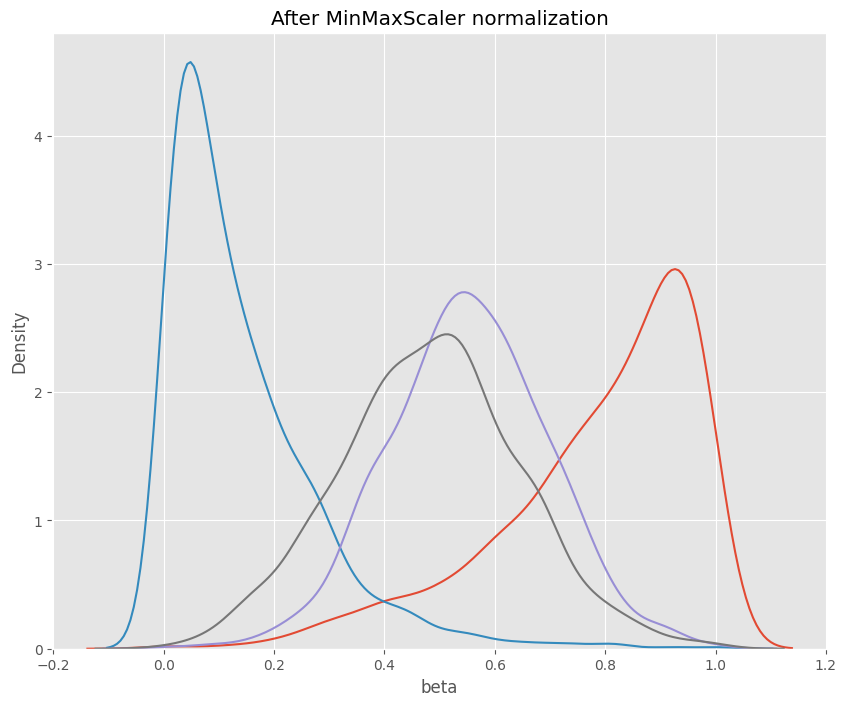

In [91]:
mm_scaler = preprocessing.MinMaxScaler()

df_mm = mm_scaler.fit_transform(df)
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After MinMaxScaler normalization')

sns.kdeplot(df_mm['beta'], ax=ax1)
sns.kdeplot(df_mm['exponential'], ax=ax1)
sns.kdeplot(df_mm['normal_p'], ax=ax1)
sns.kdeplot(df_mm['normal_l'], ax=ax1);

In [92]:
df_mm.describe()

,beta,exponential,normal_p,normal_l
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.783981,0.140471,0.551120,0.482297
std,0.183684,0.136450,0.145334,0.163992
min,0.000000,0.000000,0.000000,0.000000
25%,0.692276,0.041266,0.456837,0.375032
50%,0.834120,0.098280,0.550362,0.484741
75%,0.929157,0.196461,0.645864,0.586810
max,1.000000,1.000000,1.000000,1.000000


##### ROBUSTSCALER NORMALIZATION

![robust](images/robust.png)

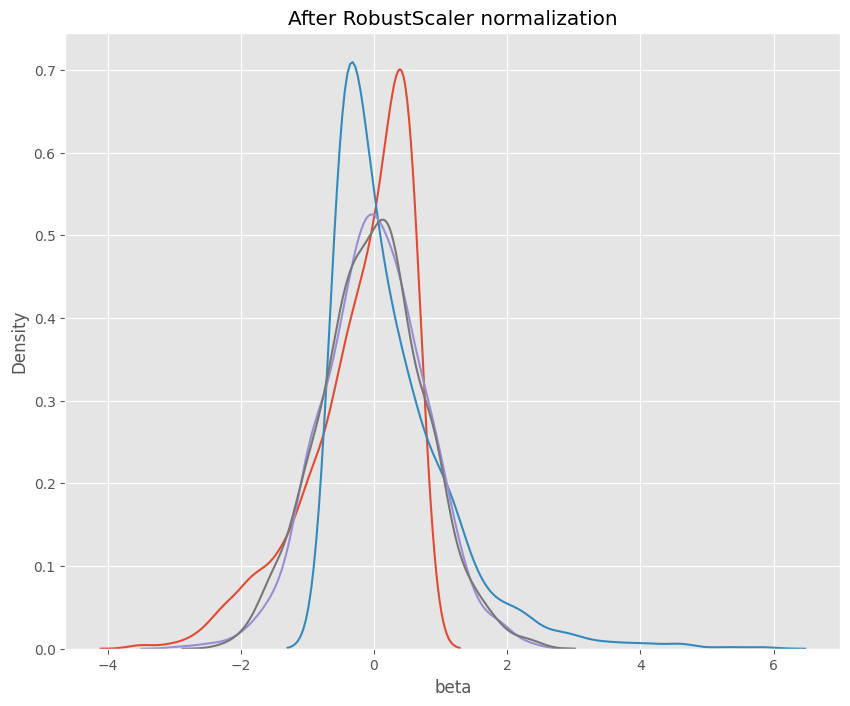

In [93]:
r_scaler = preprocessing.RobustScaler()

df_r = r_scaler.fit_transform(df)
df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After RobustScaler normalization')

sns.kdeplot(df_r['beta'], ax=ax1)
sns.kdeplot(df_r['exponential'], ax=ax1)
sns.kdeplot(df_r['normal_p'], ax=ax1)
sns.kdeplot(df_r['normal_l'], ax=ax1);

In [94]:
df_r.describe()

,beta,exponential,normal_p,normal_l
count,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000
mean,-2.116639e-01,2.718638e-01,4.011529e-03,-0.011541
std,7.754247e-01,8.792225e-01,7.688570e-01,0.774358
min,-3.521256e+00,-6.332678e-01,-2.911564e+00,-2.288916
25%,-5.987992e-01,-3.673671e-01,-4.947706e-01,-0.518040
50%,3.252607e-16,-4.011548e-17,3.390842e-16,0.000000
75%,4.012008e-01,6.326329e-01,5.052294e-01,0.481960
max,7.002654e-01,5.810261e+00,2.378706e+00,2.433017


![norm_diff](images/norm_diff.png)

##### STANDARTIZATION

![standartization](images/standartization.png)

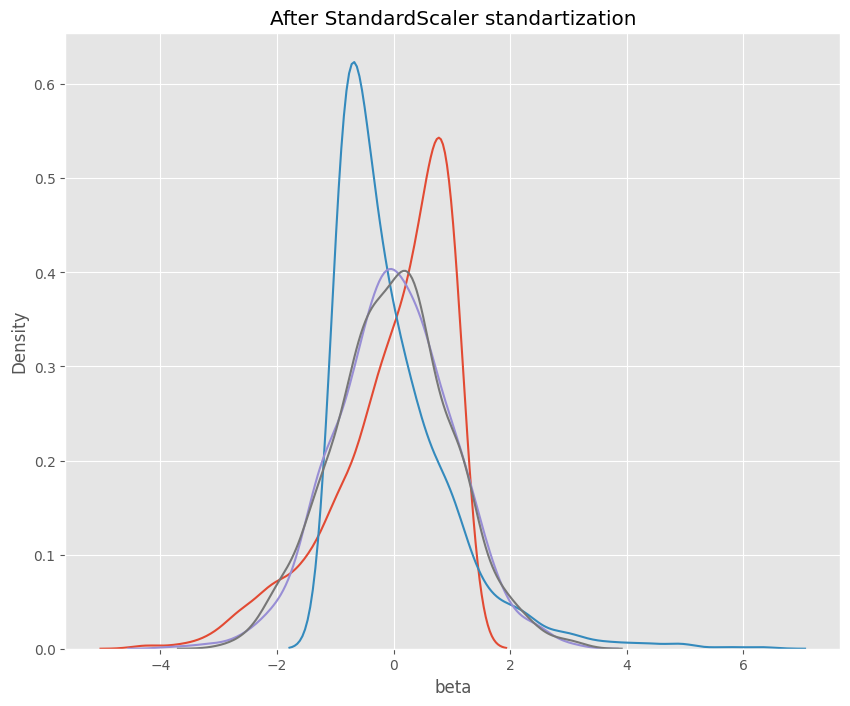

In [95]:
s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df)
df_s = pd.DataFrame(df_s, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After StandardScaler standartization')

sns.kdeplot(df_s['beta'], ax=ax1)
sns.kdeplot(df_s['exponential'], ax=ax1)
sns.kdeplot(df_s['normal_p'], ax=ax1)
sns.kdeplot(df_s['normal_l'], ax=ax1);

In [96]:
df_s.describe()

,beta,exponential,normal_p,normal_l
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,6.075140e-16,-1.776357e-18,8.100187e-16,-2.398082e-17
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-4.270238e+00,-1.029983e+00,-3.793988e+00,-2.942457e+00
25%,-4.995057e-01,-7.274049e-01,-6.490566e-01,-6.544169e-01
50%,2.731017e-01,-3.093641e-01,-5.220134e-03,1.491105e-02
75%,7.907555e-01,4.105327e-01,6.522262e-01,6.376219e-01
max,1.176627e+00,6.302351e+00,3.090149e+00,3.158464e+00


![norm_or_std](images/norm_or_std.png)

***
Нормализуйте признак price. Выберите подходящий тип нормализации, учитывая тот факт, что в данных присутствуют вина с выбросной стоимостью.

In [97]:
data['price'] = r_scaler.fit_transform(data[['price']])
round(data['price'].sum())

43501

Стандартизируйте исходный признак price.

In [98]:
data['price'] = s_scaler.fit_transform(data[['price']])
round(data['price'][129968], 2)

-0.14

***
#### Отбор признаков. Мультиколлинеарность

![attr1](images/attr_1.png)
![attr2](images/attr_2.png)

In [99]:
iris = pd.read_csv('data/iris.csv')
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


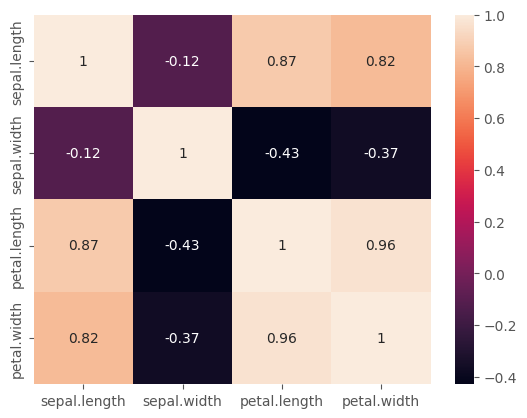

In [100]:
# отсеиваем числовые признаки и включаем отображение коэффициентов
sns.heatmap(iris.corr(numeric_only=True), annot=True);

Чтобы построить модель на этом наборе данных, сделаем отбор признаков — удалим признаки с очень сильной корреляцией (где коэффициент корреляции +/-0.7 и выше).

Начнём с самого высокого коэффициента корреляции в паре признаков: petal.width и petal.length 0,96. Удалим любой признак из этой пары, например petal.width, так как он коррелирует ещё и с признаком sepal.length:

In [101]:
iris = iris.drop(['petal.width'], axis=1)

Однако второй признак petal.length из этой пары также сильно коррелирует с признаком sepal.length. Удалим и его:

In [102]:
iris = iris.drop(['petal.length'], axis=1)

У нас осталось всего два признака с коэффициентом корреляции -0.12: sepal.width и sepal.length, и признак, который необходимо предсказать — variety. Связь между оставшимися признаками очень слабая, поэтому эти признаки будут включены в итоговый набор данных для обучения:

In [103]:
iris

,sepal.length,sepal.width,variety
0,5.1,3.5,Setosa
1,4.9,3.0,Setosa
2,4.7,3.2,Setosa
3,4.6,3.1,Setosa
4,5.0,3.6,Setosa
...,...,...,...
145,6.7,3.0,Virginica
146,6.3,2.5,Virginica
147,6.5,3.0,Virginica
148,6.2,3.4,Virginica


Это означает, что всего два признака — sepal length (длина наружной доли околоцветника) и sepal width (ширина наружной доли околоцветника) сообщают модели то же самое, что и исходный набор признаков. Мы уменьшили количество признаков, не потеряв при этом информацию о данных. А признаки petal length (длина внутренней доли околоцветника) и petal width (ширина внутренней доли околоцветник) сообщают лишнюю информацию для модели. Значит, они не нужны для построения модели.

![attr3](images/attr_3.png)

***
После проектирования признаков в нашем наборе данных для задачи винного сомелье появилось много новых данных. 

Какие из признаков имеют самую сильную корреляционную связь?

In [104]:
data.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'taster_name', 'taster_twitter_handle',
       'title', 'variety', 'winery', 'price_round', 'year', 'is_usa',
       'is_france', 'is_italy', 'old_wine', 'locality', 'population', 'area',
       'years_diff', 'year', 'taster_name_Kerin O’Keefe',
       'taster_name_Roger Voss', 'taster_name_Paul Gregutt',
       'taster_name_Alexander Peartree', 'taster_name_Michael Schachner',
       'taster_name_Anna Lee C. Iijima', 'taster_name_Virginie Boone',
       'taster_name_Matt Kettmann', 'taster_name_unknown',
       'taster_name_Sean P. Sullivan', 'taster_name_Jim Gordon',
       'taster_name_Joe Czerwinski', 'taster_name_Anne Krebiehl MW',
       'taster_name_Lauren Buzzeo', 'taster_name_Mike DeSimone',
       'taster_name_Jeff Jenssen', 'taster_name_Susan Kostrzewa',
       'taster_name_Carrie Dykes', 'taster_name_Fiona Adams',
       'taster_name_Christina Pickard', 'country_0

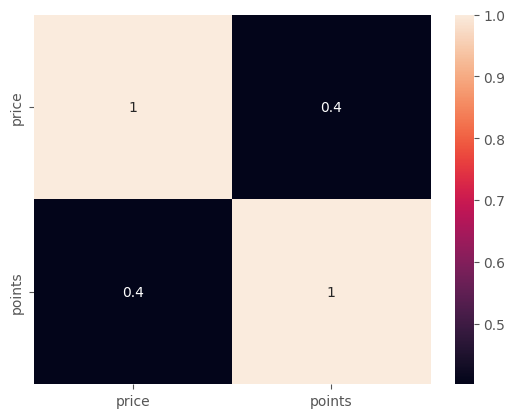

In [105]:
sns.heatmap(data[['price', 'points']].corr(numeric_only=True), annot=True);

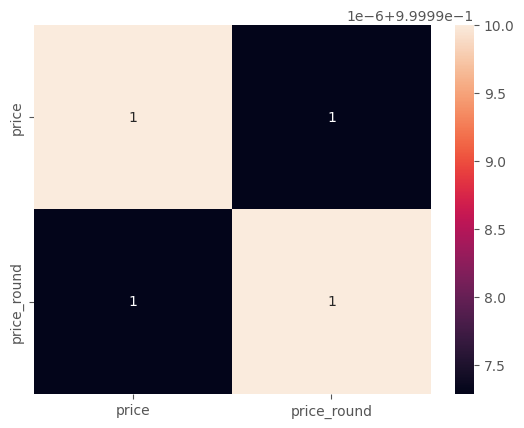

In [106]:
sns.heatmap(data[['price', 'price_round']].corr(numeric_only=True), annot=True);

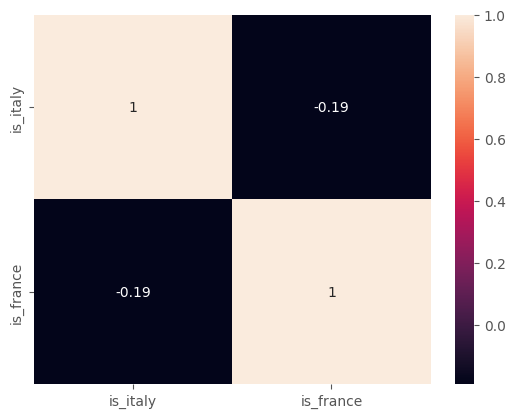

In [107]:
sns.heatmap(data[['is_italy', 'is_france']].corr(numeric_only=True), annot=True);

Проведите корреляционный анализ всего набора данных и отберите только необходимые признаки для предсказания рейтинга вина.

❗️ Удалять признак рейтинг — points нельзя!

❗️ Для простоты вычислений можете использовать только корреляцию Пирсона.

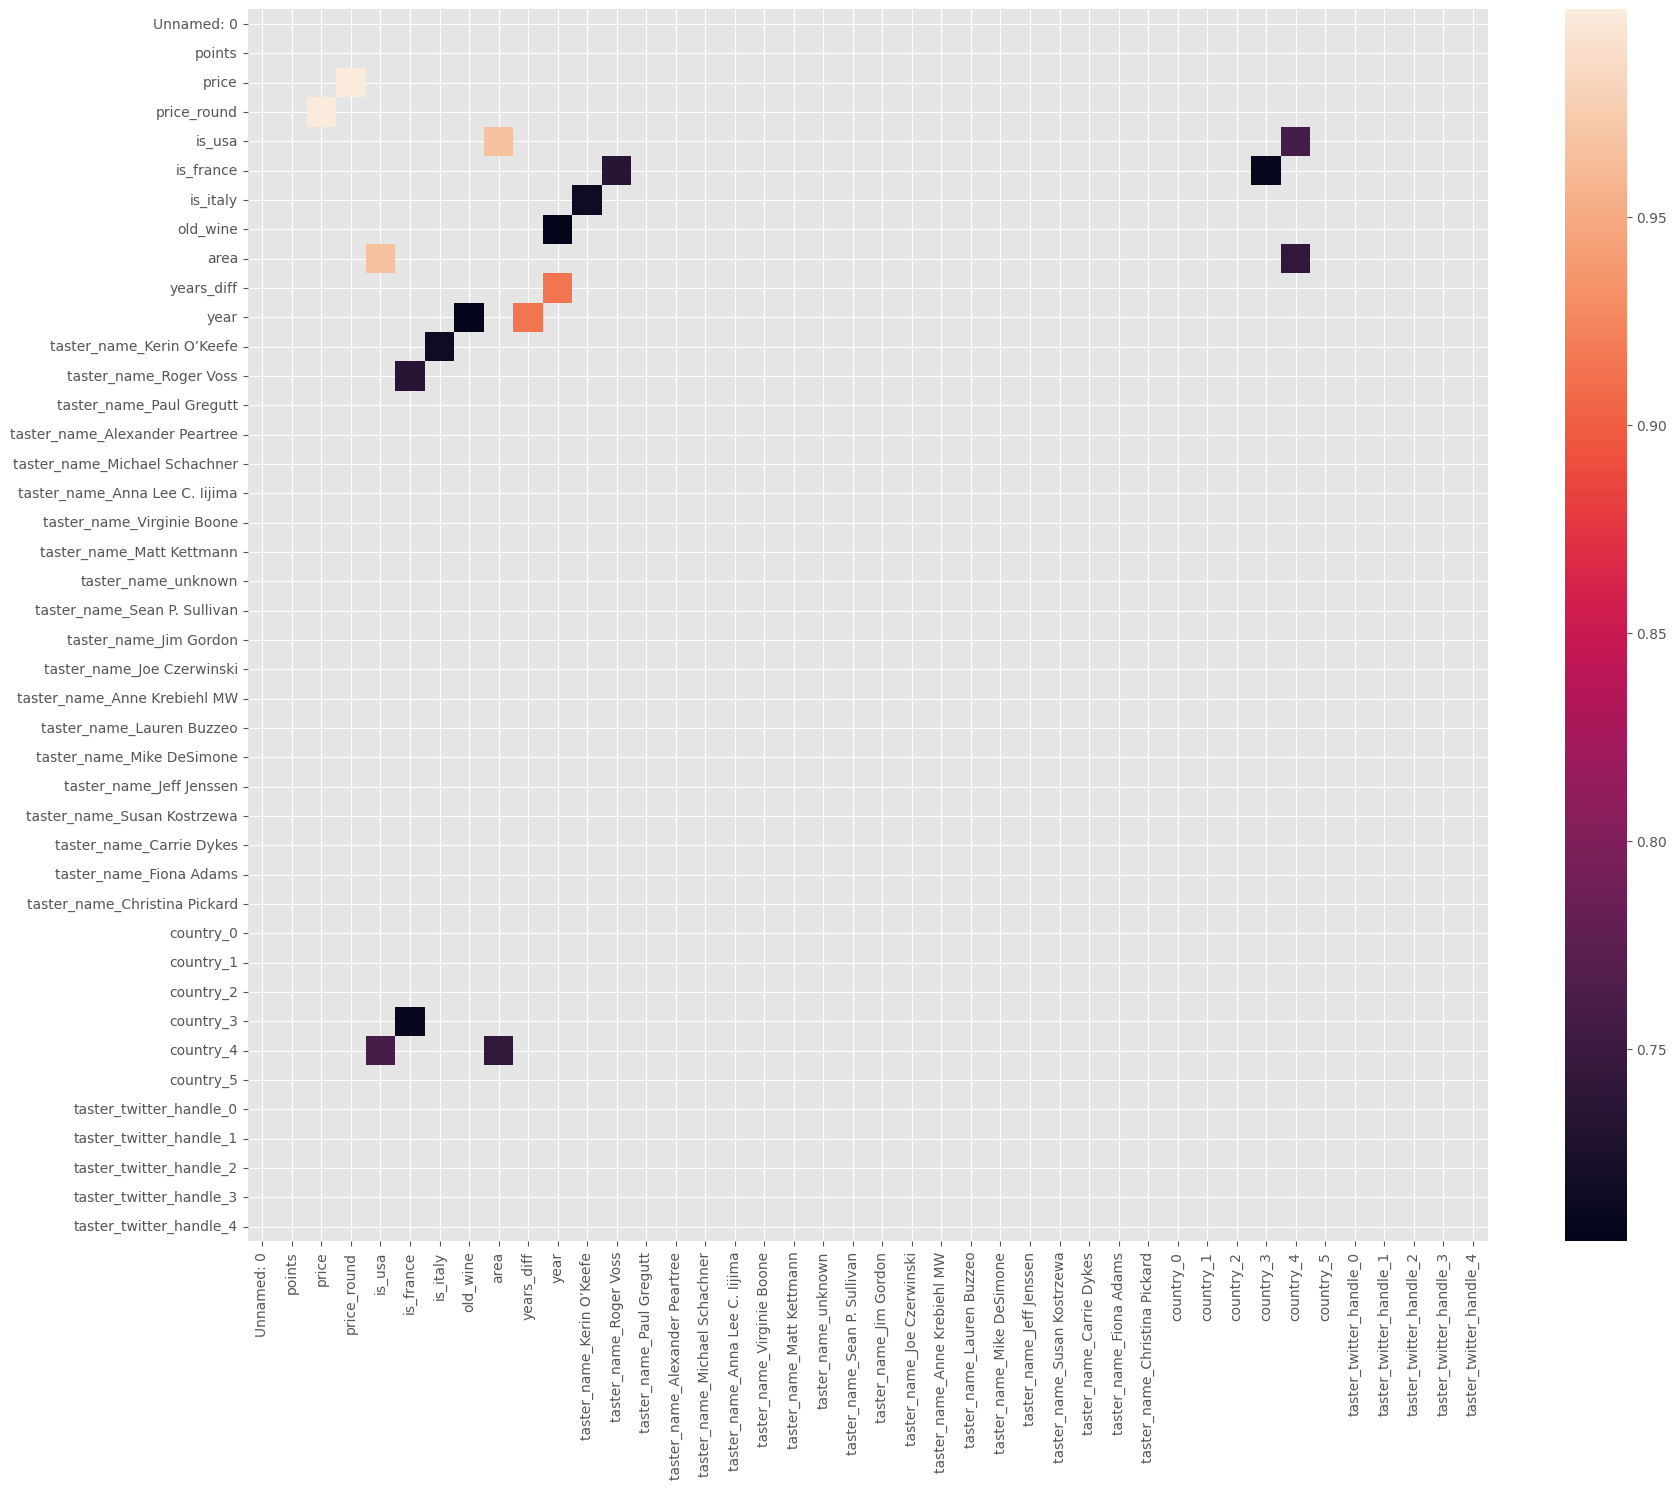

In [108]:
corr_matrix = data.corr(method='pearson', numeric_only=True)
filtered_corr_matrix = corr_matrix[((corr_matrix >= 0.7) | (corr_matrix <= -0.7)) & (corr_matrix != 1)]

plt.figure(figsize=(20, 16))
sns.heatmap(filtered_corr_matrix);

In [109]:
data = data.drop(['price', 'is_usa', 'is_france', 'is_italy', 'area'], axis=1)